# Multi-Agent Emergency Department Decision Aid (LangGraph)

This repository illustrates a multi-agent clinical reasoning system built with LangGraph and LLM tool/function calling, designed to simulate emergency department (ED) disposition decisions.

The system evaluates **whether a patient can be safely discharged, requires hospital admission, observation, or transfer**, using an iterative, role-based architecture that mirrors real ED workflows.

Given a structured ED case (history, symptoms, vitals, labs, imaging, treatments), the system:

* Runs **independent agents**: **Emergency physician**, **ED nurse**, **Social worker**

* **Aggregates their assessments** via a **Coordinator agent**

* **Iteratively requests missing information** when discharge is unsafe

* **Terminates** automatically when **Safe discharge** is achieved or **Hospitalization** (admission / observation / transfer) is decided

## Key design principles

**Role separation**
Each agent has a clearly defined scope, reducing hallucinations and improving safety.

**Structured outputs (tool calling)**
All agent outputs are validated with Pydantic schemas using models that natively support function/tool calling.

**Iterative case memory**
New labs, imaging, vitals, or treatments can be added mid-case to advance clinical reasoning, just like in a real ED.

**Explicit termination logic**
The graph stops immediately once hospitalization is chosen, preventing inappropriate discharge planning.

## Architecture overview
``` 
Physician → Nurse → Social Worker → Coordinator
                                  ↳ Loop if more data needed
                                  ↳ END if discharge or admission decided
```

The system is implemented as a LangGraph state machine, with a shared patient “chart” (CaseState) flowing through each node.

## What’s included

* Fully typed **Pydantic schemas** for Agent findings, Discharge plans, Admission decisions (service, level of care, reason)

* LangGraph execution graph with **conditional looping**

* **Graph visualization** using Mermaid

* Clean separation between Clinical reasoning, Control flow, State management

**Disclaimer** This project is for research and educational purposes only. It is not intended for clinical use and should not be used to make real patient care decisions.

In [86]:
!pip install -U langgraph langchain-core langchain-community langchain-huggingface pydantic python-dotenv
!pip install -U langchain-openai openai

   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 21.2 MB/s  0:00:00

  Attempting uninstall: openai

    Found existing installation: openai 2.9.0

   ---------------------------------------- 0/2 [openai]
   ---------------------------------------- 0/2 [openai]
    Uninstalling openai-2.9.0:
   ---------------------------------------- 0/2 [openai]
      Successfully uninstalled openai-2.9.0
   ---------------------------------------- 0/2 [openai]
   ---------------------------------------- 0/2 [openai]
   ---------------------------------------- 0/2 [openai]
   ---------------------------------------- 0/2 [openai]
   ---------------------------------------- 0/2 [openai]
   ---------------------------------------- 0/2 [openai]
   ---------------------------------------- 0/2 [openai]
   ---------------------------------------- 0/2 [openai]
   ---------------------------------------- 0/2 [openai]
   ---------------

Replace "sk-XXXXXX" with your own key.

In [113]:
import os

os.environ["OPENAI_API_KEY"]="sk-XXXXXX"

In [114]:
from __future__ import annotations

import os
import json
from typing import TypedDict, List, Dict, Any, Optional, Literal

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI

Let's use an OpenAI model, gpt-4o-mini, called through an API.

In [115]:
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")

llm = ChatOpenAI(
    model=OPENAI_MODEL,
    temperature=0.2,
)

The following **Pydantic classes** or Pydantic models enforce some data strucuture, reducing the need for extensive manual error checking.

    
**DischargeMedication** represents a single prescription at discharge and forces a certain structure: the medication name and when appropriate all the standard prescribing details in a string format.
    
**FollowUpPlan** represents a follow-up recommendation (where, when, why, etc.).
    
**DischargePlan** is the full discharge checklist and instructions package, even if the patient is not ready to leave yet.
    
* **discharge_conditions_met** is a boolean (true or false). If false, discharge is not currently safe.

* **discharge_conditions** is the checklist of what must be true before discharge (e.g., “CT negative”, “repeat vitals stable”, “pain controlled”).

* **prescriptions** a list of DischargeMedication objects defined previously

* **in_ed_actions_before_leaving** what must be completed in the ED (repeat lactate, PO challenge, social work consult).

* **follow_up** list of FollowUpPlan objects defined previously

* **discharge_instructions** patient-friendly care instructions.

* **return_precautions** explicit “come back immediately if…” warnings.

**AgentFinding** is the standard output format for each role agent (physician, nurse, social worker). It contains:

* **role** which agent produced it.

* **assessment** a narrative summary in that role’s voice.

* **missing** concrete missing data/actions needed (tests pending, repeat vitals, caregiver availability).

* **safety_risks** what could go wrong if discharged prematurely (hypoxia, falls riska).

* **discharge_ok** that role’s “go/no-go” vote for discharge right now.

* **discharge_plan** that role’s discharge conditions and instructions (even if discharge is not currently allowed).

These structured outputs help the coordinator merge and compare them.

**CoordinatorDecision** is the final authoritative decision after merging all roles. It decides:

1) **Final disposition**: "discharge", "admit", "observation", or "transfer".

If the outcome is not discharge, the coordinator also fills admit_service (medicine, surgery, geriatrics), admit_level_of_care (floor, telemetry, ICU), admit_reason (concise clinical justification).

2) **Discharge readiness and planning**:

* **can_discharge_now** boolean for discharge safety

* **rationale**: explanation of the decision

* **missing / next_questions_for_user / recommended_next_steps**: what the system needs next if still iterating

And if the disposition is discharge, it provides the consolidated plan: discharge_conditions, in_ed_actions_before_leaving, prescriptions, follow_up,  
discharge_instructions, return_precautions.

If admission is decided, the graph can stop immediately with structured admission details.


Each role agent outputs an AgentFinding consistent structure, role-specific lens that the coordinator reads and from them it produces a CoordinatorDecision. LangGraph stores these objects in state, enabling iteration: missing items accumulate, new test results are added, agents re-evaluates until discharge is safe or admission is chosen.

In [173]:
class DischargeMedication(BaseModel):
    name: str
    dose: Optional[str] = None
    route: Optional[str] = None
    frequency: Optional[str] = None
    duration: Optional[str] = None
    indication: Optional[str] = None


class FollowUpPlan(BaseModel):
    specialty_or_clinic: str
    timeframe: str
    reason: str
    how: Optional[str] = None


class DischargePlan(BaseModel):
    discharge_conditions_met: bool = Field(
        ..., description="True only if all discharge conditions are currently met."
    )
    discharge_conditions: List[str] = Field(default_factory=list)
    prescriptions: List[DischargeMedication] = Field(default_factory=list)
    in_ed_actions_before_leaving: List[str] = Field(default_factory=list)
    follow_up: List[FollowUpPlan] = Field(default_factory=list)
    discharge_instructions: List[str] = Field(default_factory=list)
    return_precautions: List[str] = Field(default_factory=list)


class AgentFinding(BaseModel):
    role: str
    assessment: str = Field(..., description="Role-specific assessment of readiness for discharge.")
    missing: List[str] = Field(default_factory=list, description="Concrete missing info, tests, or actions.")
    safety_risks: List[str] = Field(default_factory=list, description="Potential safety issues if discharged now.")
    discharge_ok: bool = Field(..., description="True only if this role thinks discharge is safe right now.")
    discharge_plan: DischargePlan = Field(..., description="Role-specific discharge plan & conditions.")


class CoordinatorDecision(BaseModel):
    disposition: Literal["discharge", "admit", "observation", "transfer"]

    admit_service: Optional[str] = None          # e.g. "medicine", "surgery", "geriatrics"
    admit_level_of_care: Optional[str] = None    # e.g. "floor", "telemetry", "ICU"
    admit_reason: Optional[str] = None          

    can_discharge_now: bool
    rationale: str

    missing: List[str] = Field(default_factory=list)
    next_questions_for_user: List[str] = Field(default_factory=list)
    recommended_next_steps: List[str] = Field(default_factory=list)

    discharge_conditions: List[str] = Field(default_factory=list)
    in_ed_actions_before_leaving: List[str] = Field(default_factory=list)
    prescriptions: List[DischargeMedication] = Field(default_factory=list)
    follow_up: List[FollowUpPlan] = Field(default_factory=list)
    discharge_instructions: List[str] = Field(default_factory=list)
    return_precautions: List[str] = Field(default_factory=list)

**CaseState** defines the single source of truth that flows through the entire LangGraph and represents an ED patient record, continuously updated as the case evolves. 

Every node (physician, nurse, social worker, coordinator) reads from and writes to this state under Role-specific agent outputs, enabling iterative reasoning.

decision: Optional[dict] is the final CoordinatorDecision object, while iteration: int tracks how many times the graph has looped to prevent infinite loops using max_iterations: int using a conservative termination (typically admission).

missing_items: List[str] is a running list of unresolved requirements for safe disposition.

In [174]:
class CaseState(TypedDict):
    case_history: str
    symptoms: str
    vitals: Dict[str, Any]
    tests_done: Dict[str, Any]          
    treatments_given: Dict[str, Any]

    physician_finding: Optional[dict]
    nurse_finding: Optional[dict]
    social_finding: Optional[dict]

    decision: Optional[dict]
    iteration: int
    max_iterations: int

    missing_items: List[str]

Each of the following variables (PHYSICIAN_SYS, NURSE_SYS, SOCIAL_SYS, COORDINATOR_SYS) is a **system prompt**: a role-defining instruction that tells the LLM who it is and what its job is for that specific step of the workflow, plus hard rules to keep outputs safe and structured.

They’re not “agents” by themselves. They’re configuration that gets passed into the LLM whenever a node runs.

In [175]:
PHYSICIAN_SYS = """You are an expert emergency physician.
Task: decide if the patient can be safely discharged from the ED NOW.
Be strict and safety-oriented. Consider red flags, unstable vitals, dangerous differentials,
and standard ED workup completeness.

Rules:
- If diagnosis unclear or high-risk, discharge_ok must be false.
- Always fill discharge_plan, even if discharge_ok is false.
- Use concrete missing items (specific tests/results/actions).
"""

NURSE_SYS = """You are an experienced ED nurse.
Task: evaluate triage stability, vitals completeness, symptom control, monitoring needs,
med admin completeness, and discharge readiness from a nursing perspective.

Rules:
- Always fill discharge_plan, even if discharge_ok is false.
- Include nursing readiness checks: repeat vitals, pain reassessment, ambulation, PO tolerance,
oxygen requirement, monitoring needs.
"""

SOCIAL_SYS = """You are an ED social worker/case manager.
Task: evaluate if discharge is safe given social needs: housing stability, caregiver support,
transportation, finances/med access, ability to follow up, language barriers, safety at home.

Rules:
- Always fill discharge_plan, even if discharge_ok is false.
- Include concrete social needs and disposition barriers.
"""

COORDINATOR_SYS = """You are the ED Disposition Coordinator.

You must choose ONE disposition:
- discharge
- admit
- observation
- transfer

Rules:
- If disposition is admit, observation, or transfer:
  * can_discharge_now MUST be false
  * Populate admit_service, admit_level_of_care, and admit_reason
  * Leave discharge-specific fields empty
- If disposition is discharge:
  * can_discharge_now MUST be true
  * Provide full discharge details

If ANY role indicates discharge is unsafe, default to admit or observation.
Return ONLY structured output matching the schema.
"""

**De-duplication Helpers** are **utility functions** used to clean and stabilize model outputs across iterations.

These helpers are not agents, not prompts, and not graph nodes.
They are part of the data hygiene layer that keeps the case state readable and safe.

* **_dedup_strings** removes duplicate strings from a list as different agents may recommend or list the same item. 
* **_dedup_dicts** removes similarly duplicate dictionaries from a list of structured objects.

In [176]:
def _dedup_strings(items: List[str]) -> List[str]:
    seen = set()
    out: List[str] = []
    for it in items or []:
        key = it.strip().lower()
        if key and key not in seen:
            seen.add(key)
            out.append(it)
    return out


def _dedup_dicts(items: List[dict]) -> List[dict]:
    seen = set()
    out: List[dict] = []
    for d in items or []:
        key = json.dumps(d, sort_keys=True)
        if key not in seen:
            seen.add(key)
            out.append(d)
    return out

**run_structured(...)** is a helper function through which the system asks the LLM to produce structured outputs.

As inputs it takes:

* **schema_model** classes defined earlier (e.g. AgentFinding, CoordinatorDecision) defining the exact output structure
* **system_prompt** specifying role-specific instructions (physician, nurse, coordinator, etc.)
* **payload** which is the current case context extracted from CaseState

The model is called but constrained to produce a structured output from the defined classes.

msgs is an ordered list of chat messages, with SystemMessage: defining the agent’s identity and rules using prompts, and HumanMessage: providing the input data that is a Python dictionnary (payload) restructured as json with identation for readability.

obj is the structured result of the model call and then transformed to a python dict through model_dump()

In [177]:
def run_structured(schema_model: type[BaseModel], system_prompt: str, payload: dict) -> dict:

    model = llm.with_structured_output(schema_model) 
    msgs = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=json.dumps(payload, indent=2)),
    ]
    obj = model.invoke(msgs)  
    return obj.model_dump()

**LangGraph nodes** represent individual professional roles in the emergency department workflow. 

They use the shared CaseState, invoke a role-specific LLM through run_structured with strict structure, and Write the outputs back into the state.

In [178]:
def physician_node(state: CaseState) -> CaseState:
    payload = {
        "case_history": state["case_history"],
        "symptoms": state["symptoms"],
        "vitals": state["vitals"],
        "tests_done": state["tests_done"],
        "treatments_given": state["treatments_given"],
        "known_missing": state["missing_items"],
    }
    state["physician_finding"] = run_structured(AgentFinding, PHYSICIAN_SYS, payload)
    return state


def nurse_node(state: CaseState) -> CaseState:
    payload = {
        "case_history": state["case_history"],
        "symptoms": state["symptoms"],
        "vitals": state["vitals"],
        "tests_done": state["tests_done"],
        "treatments_given": state["treatments_given"],
        "known_missing": state["missing_items"],
    }
    state["nurse_finding"] = run_structured(AgentFinding, NURSE_SYS, payload)
    return state


def social_worker_node(state: CaseState) -> CaseState:
    payload = {
        "case_history": state["case_history"],
        "symptoms": state["symptoms"],
        "vitals": state["vitals"],
        "tests_done": state["tests_done"],
        "treatments_given": state["treatments_given"],
        "known_missing": state["missing_items"],
    }
    state["social_finding"] = run_structured(AgentFinding, SOCIAL_SYS, payload)
    return state

The **Coordinator Node** is responsible for combining independant roles findings into a single disposition and producing a final structured decision (CoordinatorDecision).

* First it **packages everything** the coordinator needs to make a final disposition decision in the payload dictionary. 
* Then it **invokes the LLM** under COORDINATOR_SYS and returns a CoordinatorDecision schema structured including the **decision to admit or not**. 
* Then it **extracts each role’s discharge_plan** if they were specified and **integrates** their different class elements.
* The **state is updated** with new missing items and the decision, plus the iteration is advanced.

In [179]:
def coordinator_node(state: CaseState) -> CaseState:
    payload = {
        "case_history": state["case_history"],
        "symptoms": state["symptoms"],
        "vitals": state["vitals"],
        "tests_done": state["tests_done"],
        "treatments_given": state["treatments_given"],
        "physician_finding": state["physician_finding"],
        "nurse_finding": state["nurse_finding"],
        "social_finding": state["social_finding"],
        "prior_missing": state["missing_items"],
        "iteration": state["iteration"],
        "max_iterations": state["max_iterations"],
    }

    # Coordinator produces the authoritative disposition + missing list
    decision = run_structured(CoordinatorDecision, COORDINATOR_SYS, payload)

    # Merge role discharge plans into coordinator decision 
    pf = (state["physician_finding"] or {}).get("discharge_plan", {}) or {}
    nf = (state["nurse_finding"] or {}).get("discharge_plan", {}) or {}
    sf = (state["social_finding"] or {}).get("discharge_plan", {}) or {}

    decision["discharge_conditions"] = _dedup_strings(
        (decision.get("discharge_conditions", []) or [])
        + (pf.get("discharge_conditions", []) or [])
        + (nf.get("discharge_conditions", []) or [])
        + (sf.get("discharge_conditions", []) or [])
    )

    decision["in_ed_actions_before_leaving"] = _dedup_strings(
        (decision.get("in_ed_actions_before_leaving", []) or [])
        + (pf.get("in_ed_actions_before_leaving", []) or [])
        + (nf.get("in_ed_actions_before_leaving", []) or [])
        + (sf.get("in_ed_actions_before_leaving", []) or [])
    )

    decision["discharge_instructions"] = _dedup_strings(
        (decision.get("discharge_instructions", []) or [])
        + (pf.get("discharge_instructions", []) or [])
        + (nf.get("discharge_instructions", []) or [])
        + (sf.get("discharge_instructions", []) or [])
    )

    decision["return_precautions"] = _dedup_strings(
        (decision.get("return_precautions", []) or [])
        + (pf.get("return_precautions", []) or [])
        + (nf.get("return_precautions", []) or [])
        + (sf.get("return_precautions", []) or [])
    )

    decision["follow_up"] = _dedup_dicts(
        (decision.get("follow_up", []) or [])
        + (pf.get("follow_up", []) or [])
        + (nf.get("follow_up", []) or [])
        + (sf.get("follow_up", []) or [])
    )

    decision["prescriptions"] = _dedup_dicts(
        (decision.get("prescriptions", []) or [])
        + (pf.get("prescriptions", []) or [])
        + (nf.get("prescriptions", []) or [])
        + (sf.get("prescriptions", []) or [])
    )

    new_missing = decision.get("missing", []) or []
    state["missing_items"] = _dedup_strings(new_missing)

    # Save decision + advance iteration counter
    state["decision"] = decision
    state["iteration"] += 1
    return state

**should_continue** is the termination gate of the LangGraph workflow, **stopping when admission, discharge, or transfer** is decided, enforcing iteration limits for safety, and **otherwise looping back** for further clinical review.

In [180]:
def should_continue(state: CaseState) -> str:
    decision = state.get("decision") or {}
    disposition = decision.get("disposition")

    print(
        f"[ITERATION CHECK] iteration={state['iteration']}, "
        f"disposition={disposition}, can_discharge_now={decision.get('can_discharge_now')}"
    )

    # Stop immediately if hospitalization (or transfer) is decided
    if disposition in {"admit", "observation", "transfer"}:
        print("→ END (hospital-level disposition decided)")
        return END

    if decision.get("can_discharge_now") is True:
        print("→ END (discharge ready)")
        return END

    if state["iteration"] >= state["max_iterations"]:
        print("→ END (max iterations reached)")
        return END

    print("→ LOOP BACK TO physician")
    return "physician"

**build_graph** defines the full ED disposition workflow by registering role-based nodes, setting execution order, adding conditional looping logic, and compiling everything into an executable LangGraph state machine.
    
**StateGraph** creates a new LangGraph state machine, declares that every node will read and write the same shared state that must conform to the CaseState schema.

After coordinator_node runs, LangGraph calls should_continue(state) function that returns either END → stop the graph or "physician" → loop back

In [181]:
def build_graph():
    g = StateGraph(CaseState)
    g.add_node("physician", physician_node)
    g.add_node("nurse", nurse_node)
    g.add_node("social_worker", social_worker_node)
    g.add_node("coordinator", coordinator_node)

    g.set_entry_point("physician")
    g.add_edge("physician", "nurse")
    g.add_edge("nurse", "social_worker")
    g.add_edge("social_worker", "coordinator")
    g.add_conditional_edges("coordinator", should_continue)

    return g.compile()

**update_case** function allows to add new clinical information to the case between iterations of the graph.

In [182]:
def update_case(
    state: CaseState,
    *,
    history=None,
    symptoms=None,
    vitals=None,
    tests=None,
    treatments=None,
):
    if history is not None:
        state["case_history"] = (state["case_history"] + "\n" + str(history)).strip()
    if symptoms is not None:
        state["symptoms"] = (state["symptoms"] + "\n" + str(symptoms)).strip()
    if vitals is not None:
        state["vitals"].update(vitals)
    if tests is not None:
        state["tests_done"].update(tests)
    if treatments is not None:
        state["treatments_given"].update(treatments)
    return state


**show_graph** displays the LangGraph workflow diagram

In [183]:
def show_graph(app):
    from IPython.display import Image, display
    png_bytes = app.get_graph().draw_mermaid_png()
    display(Image(png_bytes))

In Jupyter, if __name__ == "__main__": is not required, but keeping it makes your notebook code portable, reusable, and clearly marks the main execution entry point for future .py usage

* the graph is built and the diagram shown
* state is defined (patient case)
* the entire multi-agent LangGraph workflow is run on the current patient case (state) using app.invoke(state)
* the final disposition is printed with the remaining unresolved information 

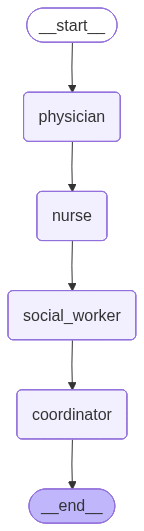

[ITERATION CHECK] iteration=1, disposition=admit, can_discharge_now=False
→ END (hospital-level disposition decided)

=== COORDINATOR DECISION ===
{
  "disposition": "admit",
  "admit_service": "Internal Medicine",
  "admit_level_of_care": "Floor",
  "admit_reason": "Patient requires further evaluation and monitoring due to unstable vital signs, pending test results, and high risk for complications.",
  "can_discharge_now": false,
  "rationale": "Discharge is not safe due to the patient's unstable vital signs, pending test results, and high risk for dehydration and other complications.",
  "missing": [
    "Results of CBC, CMP, Lactate, CRP, Stool studies, CT Abd/Pelvis"
  ],
  "next_questions_for_user": [],
  "recommended_next_steps": [
    "Admit to Internal Medicine for further evaluation and management.",
    "Monitor vital signs closely and reassess as needed."
  ],
  "discharge_conditions": [
    "Pending test results for CBC, CMP, Lactate, CRP, Stool studies, CT Abd/Pelvis",
   

In [184]:
if __name__ == "__main__":
    app = build_graph()

    # ---- SHOW GRAPH IMAGE ----
    show_graph(app)

    state: CaseState = {
        "case_history": (
            "95-year-old man brought to ED with diffuse constant abdominal pain + diarrhea "
            "(loose stools per day in diaper), reduced oral intake. Advanced Alzheimer’s per caregiver. "
            "Medications unknown."
        ),

        "symptoms": "Diffuse constant abdominal pain. Diarrhea. No melena observed. Reduced PO intake.",

        "vitals": {
            "BP": "168/92",
            "HR": 103,
            "RR": 18,
            "Temp": "37.9C",
            "SpO2": "90% RA",
            "Rhythm": "irregular",
        },

        "tests_done": {
            "CBC": "ordered",
            "CMP": "ordered",
            "Lactate": "ordered",
            "CRP": "ordered",
            "Stool studies": "ordered",
            "CT Abd/Pelvis": "requested",
        },

        "treatments_given": {
            "IV access": "placed",
            "IV fluids": "started",
            "Pain control": "started (careful monitoring)",
            "Home_PO_medications": {
                "Acetaminophen": "650 mg PO q6–8h PRN pain",
                "Amlodipine": "5 mg PO daily",
                "Donepezil": "5 mg PO nightly",
                "Memantine": "5 mg PO BID (renally adjusted)",
                "Furosemide": "20 mg PO daily",
                "Omeprazole": "20 mg PO daily",
                "Senna": "1 tab PO nightly PRN constipation",
                "Vitamin D": "800 IU PO daily",
            },
        },

        "physician_finding": None,
        "nurse_finding": None,
        "social_finding": None,

        "decision": None,
        "iteration": 0,
        "max_iterations": 3,
        "missing_items": [],
    }

    out = app.invoke(state)

    print("\n=== COORDINATOR DECISION ===")
    print(json.dumps(out["decision"], indent=2))

    print("\n=== CASE MEMORY (missing_items) ===")
    print(json.dumps(out["missing_items"], indent=2))

In [185]:
decision = out["decision"]

print("=== FINAL DISPOSITION ===")
print("disposition:", decision["disposition"])
print("can_discharge_now:", decision["can_discharge_now"])

if decision["disposition"] != "discharge":
    print("admit_service:", decision.get("admit_service"))
    print("admit_level_of_care:", decision.get("admit_level_of_care"))
    print("admit_reason:", decision.get("admit_reason"))

print("\n=== MISSING ITEMS ===")
print(out["missing_items"])

=== FINAL DISPOSITION ===
disposition: admit
can_discharge_now: False
admit_service: Internal Medicine
admit_level_of_care: Floor
admit_reason: Patient requires further evaluation and monitoring due to unstable vital signs, pending test results, and high risk for complications.

=== MISSING ITEMS ===
['Results of CBC, CMP, Lactate, CRP, Stool studies, CT Abd/Pelvis']


**prepare_for_rerun** function prepares an existing patient case to be re-run through the graph after new information has been added and does not create a new case.

In [186]:
def prepare_for_rerun(state: CaseState) -> CaseState:
    state["iteration"] = 0
    state["decision"] = None
    state["physician_finding"] = None
    state["nurse_finding"] = None
    state["social_finding"] = None
    return state

Here the **final state from the last run (out) gets new information** that became available, and the **reasoning agents are reset** so the graph can re-evaluate cleanly with the new facts.

The model can be rerun.

In [187]:
out = prepare_for_rerun(
    update_case(
        out,
        history=(
            "Terminal renal failure. Family prefers dying at home rather than in hospital; "
            "only wants admission if there is a real possibility of being sent back home."
        ),

        tests={
            "Creatinine": "7.8 mg/dL",
            "Blood urea nitrogen": "142 mg/dL",
            "eGFR": "6 mL/min/1.73 m2",
            "Potassium": "6.6 mmol/L",
            "Bicarbonate": "12 mmol/L",
            "Phosphate": "7.8 mg/dL",
            "Calcium": "7.4 mg/dL",
            "Hemoglobin": "8.2 g/dL",
            "Urinalysis": "proteinuria",
            "Lactate": "6.8 mmol/L",
            "Arterial pH": "7.12",
            "Anion gap": "26 mmol/L",
            "White blood cell count": "24 x10^9/L",
            "LDH": "980 U/L",
            "AST": "310 U/L",
            "ALT": "265 U/L",
            "D-dimer": "markedly elevated",
            "Amylase": "185 U/L",
            "INR": "1.9",
            "CT Abd/Pelvis (non-contrast)": (
                "Segmental circumferential thickening of small bowel loops with heterogeneous attenuation; "
                "dilated fluid-filled small intestine with air-fluid levels; pneumatosis intestinalis; "
                "mesenteric fat stranding suggesting ischemic inflammation; advanced vascular calcifications "
                "of aorta and mesenteric vessels. Overall pattern compatible with advanced bowel ischemia "
                "in a high-risk elderly patient."
            ),
        },
        treatments={
            "IV_fluids": "Cautious isotonic fluids 250 mL bolus, reassess due to renal failure",
            "Pain_control": "Low-dose IV acetaminophen; avoid NSAIDs",
            "Nutrition": "NPO",
        },
    )
)

out = app.invoke(out)

print("disposition:", out["decision"]["disposition"])
print("can_discharge_now:", out["decision"]["can_discharge_now"])
print("missing_items:", out["missing_items"])

[ITERATION CHECK] iteration=1, disposition=admit, can_discharge_now=False
→ END (hospital-level disposition decided)
disposition: admit
can_discharge_now: False
missing_items: ['Results of CBC, CMP, CRP, Stool studies, and Lactate are pending.', "Clinical evaluation of the patient's abdominal pain and overall condition after test results are available."]


We see here the **limits of the model** that still admits the patient, even if it seems difficult to imagine the patient can improve in the hospital. **Assessing severity** of a case is extremely difficult in general in a clinical setting.
    
For such a model, it would be also critical to review **safety** and ensure **compliance, for instance with HIPAA**.

How to **evaluate** it is also critical: which **benchmark**, or using **statistical methods** to measure **safety or cost-efficiency** is paramount. 

Key questions are also how to **bring it to production / launch** and **integrate it into real-life workflow** and ensure **human in the loop processes**.